# The simple 2-bin demo w/ sigmoid activation


![](assets/training.gif)

In [1]:
import time

import jax
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
import jax.random
from jax.random import PRNGKey
import numpy as np
from functools import partial

import pyhf
pyhf.set_backend('jax')
pyhf.default_backend = pyhf.tensor.jax_backend(precision='64b')

from neos import data, cls, makers

rng = PRNGKey(22)

### Initialise network using `jax.experimental.stax`

In [2]:
init_random_params, predict = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1),
    stax.Sigmoid
)

### Initialse tools from `neos`:

The way we initialise in `neos` is to define functions that make a statistical model from histograms, which in turn are themselves made from a predictive model, such as a neural network. Here's some detail on the unctions used below:

- `hists_from_nn_three_blobs(predict)` uses the nn decision function `predict` defined in the cell above to form histograms from signal and background data, all drawn from multivariate normal distributions with different means. Two background distributions are sampled from, which is meant to mimic the situation in particle physics where one has a 'nominal' prediction for a nuisance parameter and then an alternate value (e.g. from varying up/down by one standard deviation), which then modifies the background pdf. Here, we take that effect to be a shift of the mean of the distribution. The value for the background histogram is then the mean of the resulting counts of the two modes, and the uncertainty can be quantified through the count standard deviation.
- `nn_hepdata_like(hmaker)` uses `hmaker` to construct histograms, then feeds them into the `neos.models.hepdata_like` function that constructs a pyhf-like model. This can then be used to call things like `logpdf` and `expected_data` downstream.
- `cls_maker` takes a model-making function as it's primary argument, which is fed into functions from `neos.fit` that minimise the `logpdf` of the model in both a constrained (fixed parameter of interest) and a global way. Moreover, these fits are wrapped in a function that allows us to calculate gradients through the fits using *fixed-point differentiation*. This allows for the calculation of both the profile likelihood and its gradient, and then the same for $\mathsf{cl_s}$ :)

All three of these methods return functions. in particular, `cls_maker` returns a function that differentiably calculates $\mathsf{cl_s}$ values, which is our desired objective to minimise.

In [3]:
dgen = data.generate_blobs(rng,blobs=4) 
hmaker = makers.hists_from_nn(dgen, predict, method='kde')
nnm = makers.nn_histosys(hmaker)
get_cls = cls.expected_CLs_upper_limit(nnm, solver_kwargs=dict(pdf_transform=True))

# Specify our hyperparameters ahead of time for the kde histograms
get_loss = partial(get_cls, hyperparams=dict(bins=np.linspace(0,1,4),bandwidth=0.27))

# loss returns a list of metrics -- let's just index into one (CLs)
def loss(test_mu, params):
    return get_loss(test_mu, params)[0]

4 (500, 2)


### Randomly initialise nn weights and check that we can get the gradient of the loss wrt nn params

In [5]:
_, network = init_random_params(jax.random.PRNGKey(13), (-1, 2))
jax.grad(loss(test_mu = 1.0, params = network)

(500, 2)
[5.13706324 9.32247891 4.30051851] float64 <class 'jax.interpreters.xla.DeviceArray'> (3,)
(500, 2)
Traced<ShapedArray(float64[3]):JaxprTrace(level=0/0)> float64 <class 'jax.interpreters.partial_eval.JaxprTracer'> (3,)


[DeviceArray(0.06836535, dtype=float64)]

### Define training loop!

In [12]:
# jit_loss = jax.jit(loss)

opt_init, opt_update, opt_params = optimizers.adam(1e-3)

# @jax.jit
def update_and_value(i, opt_state, mu):
    net = opt_params(opt_state)
    value, grad = jax.value_and_grad(loss)(net, mu)
    return opt_update(i, grad, state), value, net


def train_network(N):
    cls_vals = []
    _, network = init_random_params(jax.random.PRNGKey(1), (-1, 2))
    state = opt_init(network)
    losses = []

    # parameter update function
    # @jax.jit
    def update_and_value(i, opt_state, mu):
        net = opt_params(opt_state)
        value, grad = jax.value_and_grad(loss)(net, mu)
        return opt_update(i, grad, state), value, net

    for i in range(N):
        start_time = time.time()
        state, value, network = update_and_value(i, state, 1.0)
        epoch_time = time.time() - start_time
        losses.append(value)
        metrics = {"loss": losses}
        yield network, metrics, epoch_time

### Plotting helper function for awesome animations :)

In [13]:
def plot(axarr, network, metrics, hm, maxN):
    ax = axarr[0]
    g = np.mgrid[-5:5:101j, -5:5:101j]
    levels = np.linspace(0, 1, 21)
    ax.contourf(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 2)[:, :, 0],
        levels=levels,
        cmap="BrBG",
    )
    ax.contour(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 2)[:, :, 0],
        colors="w",
        levels=levels,
    )
    ax.scatter(hm.sig[:, 0], hm.sig[:, 1], alpha=0.25, c="C9", label="sig")
    ax.scatter(hm.bkg1[:, 0], hm.bkg1[:, 1], alpha=0.17, c="C1", label="bkg1")
    ax.scatter(hm.bkg2[:, 0], hm.bkg2[:, 1], alpha=0.17, c="C1", label="bkg2")
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax = axarr[1]
    ax.axhline(0.05, c="slategray", linestyle="--")
    ax.plot(metrics["loss"], c="steelblue", linewidth=2.0)

    ax.set_ylim(0, 0.6)
    ax.set_xlim(0, maxN)
    ax.set_xlabel("epoch")
    ax.set_ylabel(r"$cl_s$")

    ax = axarr[2]
    s, b, db = hm(network)
    ax.bar([0, 1], b, color="C1", label="bkg")
    ax.bar([0, 1], s, bottom=b, color="C9", label="sig")
    ax.bar([0, 1], db, bottom=b - db / 2.0, alpha=0.4, color="black", label="bkg error")
    ax.set_ylim(0, 100)
    ax.set_ylabel("frequency")
    ax.set_xlabel("nn output")

## Install celluloid for animations!

In [ ]:
!python -m pip install celluloid

### Let's run it!!

epoch 0: CLs = 0.0668151417555447, took 1.227747917175293s
epoch 1: CLs = 0.4812187026727466, took 1.209420919418335s
epoch 2: CLs = 0.34485858656081003, took 1.2073898315429688s
epoch 3: CLs = 0.19411719551886097, took 1.1816728115081787s
epoch 4: CLs = 0.10163415542805421, took 1.1903471946716309s
epoch 5: CLs = 0.05399817989278066, took 1.1896989345550537s
epoch 6: CLs = 0.02977740063165668, took 1.2036521434783936s
epoch 7: CLs = 0.01741551274214803, took 1.1808619499206543s
epoch 8: CLs = 0.011503335451359176, took 1.196781873703003s
epoch 9: CLs = 0.009081220748150098, took 1.25850510597229s
epoch 10: CLs = 0.008152659758190905, took 1.3902599811553955s
epoch 11: CLs = 0.007559012282486455, took 1.3107590675354004s
epoch 12: CLs = 0.006885640635478252, took 1.2622408866882324s
epoch 13: CLs = 0.006118936311778622, took 1.2121930122375488s
epoch 14: CLs = 0.005352290588705122, took 1.2396550178527832s
epoch 15: CLs = 0.0046583337729262375, took 1.2629036903381348s
epoch 16: CLs = 

KeyboardInterrupt: 

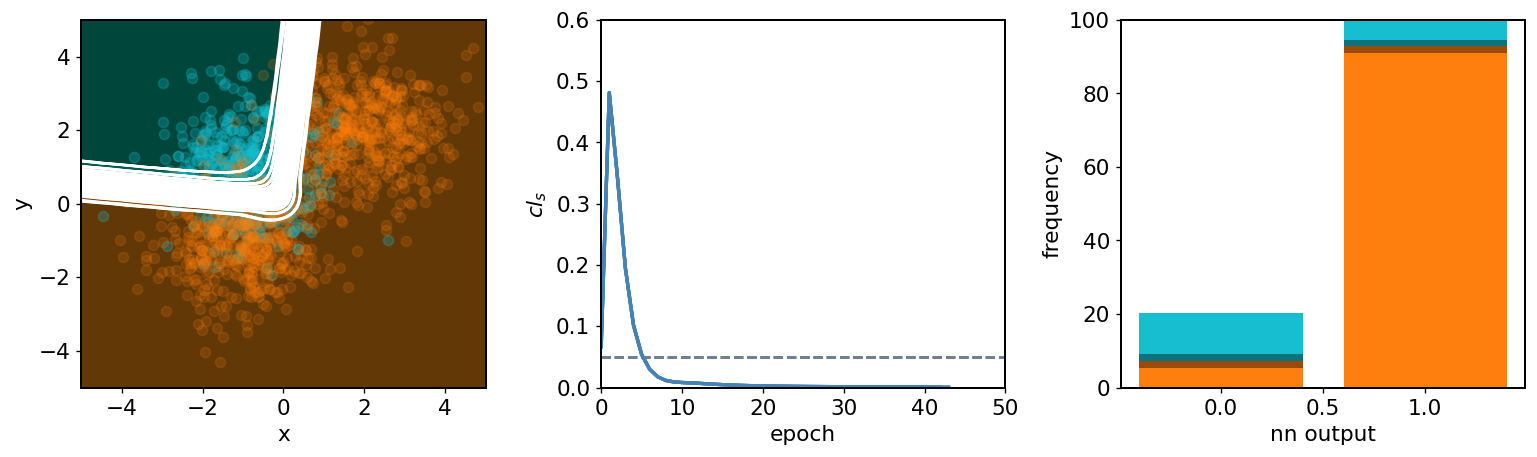

In [15]:
# slow
import numpy as np
from IPython.display import HTML

from matplotlib import pyplot as plt

plt.rcParams.update(
    {
        "axes.labelsize": 13,
        "axes.linewidth": 1.2,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "figure.figsize": [13.0, 4.0],
        "font.size": 13,
        "xtick.major.size": 3,
        "ytick.major.size": 3,
        "legend.fontsize": 11,
    }
)


fig, axarr = plt.subplots(1, 3, dpi=120)

maxN = 50  # make me bigger for better results!

animate = True  # animations fail tests...

if animate:
    from celluloid import Camera

    camera = Camera(fig)

# Training
for i, (network, metrics, epoch_time) in enumerate(train_network(maxN)):
    print(f"epoch {i}:", f'CLs = {metrics["loss"][-1]}, took {epoch_time}s')
    if animate:
        plot(axarr, network, metrics, nnm.hm, maxN=maxN)
        plt.tight_layout()
        camera.snap()
        if i % 10 == 0:
            camera.animate().save("softmax_animation.gif", writer="imagemagick", fps=8)
            # HTML(camera.animate().to_html5_video())
if animate:
    camera.animate().save("softmax_animation.gif", writer="imagemagick", fps=8)